In [3]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Plotting and visualization
import matplotlib.pyplot as plt, savefig
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from matplotlib.font_manager import fontManager, FontProperties

# Natural Language Processing
import jieba

# Networkx for graph related tasks
import networkx as nx

In [4]:
# Setup font to adapt Chinese
# Define the path to the font file
path = 'NotoSansSC-VariableFont_wght.ttf'
fontManager.addfont(path)
prop = FontProperties(fname=path)
sns.set(font=prop.get_name())

# Setup words to ignore
SKIPWORDS = {'[Photo]', '[Emoji]', '[Video]', '[Location]', 'nan'}

# Setup color palette
colors = ['#FCFCFC','#F2E8DA','#EFCFBA','#FFBE98','#FA9A85','#DE8286','#964F4C','#752329','#4E170B']
sentiment_colors = ['#0F4C81', '#A5B8D0', '#E0E0E0', '#FFD787', '#FFAF0F']

## 0. Data Import and Processing

In [9]:
## You can use this github project to export your Wechat messages
## https://github.com/BlueMatthew/WechatExporter

# Import the text file
with open('messages.txt', 'r') as file:
    lines = file.readlines()
    
# Set up all the nicknames to facilitate data cleaning
users = ['小美', '小帅', 'AAAA', 'BBBB']
first_two_chars_users = [user[0:2] for user in users]

# Extract user, date, time, and msg from each line
data = []
for line in lines:
    # Check if the line starts with a valid character from the list
    if line[0:2] in first_two_chars_users and "(" in line and ")" in line and ":" in line:
        user_end = line.find(' (')
        user = line[0:user_end]
        
        date_start = user_end + 2
        date_end = date_start + 10
        date = line[date_start:date_end]
        
        time_start = date_end + 1
        time_end = time_start + 8
        time = line[time_start:time_end]
        
        msg = line[time_end+2:]
        data.append([user, date, time, msg[:-1]])

# Convert list to DataFrame
df = pd.DataFrame(data, columns=['user', 'date', 'time', 'msg'])

In [10]:
# Create time related column
df['dow'] = pd.to_datetime(df['date']).dt.dayofweek 
df['dow'] = df['dow'] + 1
df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week 
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
df['year'] = pd.to_datetime(df['date']).dt.year
df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')

# Filter only records this year
df = df[df['year']==2023].reset_index(drop=True)
len(df)

8025

## Active Heatmap

In [12]:
# Function to plot message count by year month
def plot_bar_by_year_month(df, username):
    """
    Plot a bar chart of message counts by year-month.
    If a username is provided, filter the data for that user.
    """
    username = 'Group' if username is None else username
    df = df[df['user'] == username] if username != 'Group' else df

    # Group message counts by year-month
    monthly_counts = df.groupby('year_month').size().reset_index(name='counts')
    
    # Plot 
    plt.figure(figsize=(12,4))
    ax = sns.barplot(monthly_counts, x="year_month", y="counts", estimator="sum", color='#FFBE98', errorbar=None)
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.set_facecolor('white')
    plt.title('Message Counts by Year Month - ' + username)
    plt.ylabel('Counts')
    plt.xlabel('Year month')
    plt.xticks(rotation=60)
    plt.savefig(('msg_by_month_'+username+'.png'), format='png', transparent=True, bbox_inches='tight') 
    plt.show()

# Function to plot message count by user (only top 20 users)
def plot_bar_by_user(df):
    """
    Plot a bar chart of message counts by user.
    Only includes the top 20 users.
    """
    # Group message counts by user and sort
    user_counts = df.groupby('user').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False) 
    user_counts = user_counts.reset_index(drop=True)
    
    # Plot 
    plt.figure(figsize=(12,4))
    ax = sns.barplot(user_counts[0:20], x="counts", y="user", estimator="sum", color='#FFBE98', errorbar=None)
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.set_facecolor('white')
    
    plt.title('Top Users by Message Counts')
    plt.ylabel('User')
    plt.xlabel('Counts')
    plt.xticks(rotation=60)
    plt.savefig('msg_by_user.png', format='png', transparent=True, bbox_inches='tight')
    plt.show()

# Function to plot message count by day of week and hour
def plot_heatmap_by_dow_hour(df, username):
    """
    Plot a heatmap of message counts by day of week and hour.
    If a username is provided, filter the data for that user.
    """
    username = 'Group' if username is None else username
    df = df[df['user'] == username] if username != 'Group' else df
    
    # Create pivot table for heatmap
    pivot_table = df[['dow','hour']].pivot_table(index='dow', columns='hour', aggfunc=len, fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(12,4))
    sns.heatmap(pivot_table, cmap=colors, cbar=True)
    plt.title('Heatmap of Message Counts by Day of Week and Hour - '+ username)
    plt.ylabel('Day of Week')
    plt.xlabel('Hour')
    plt.savefig(('msg_heatmap_'+username+'.png'), format='png', transparent=True, bbox_inches='tight')
    plt.show()

## Generate Wordcloud

In [13]:
# Import library
from stopwordsiso import stopwords

# Setup stopwords
ZHSTOPWORDS = stopwords("zh")
MYSTOPWORDS = {'的', '了', '你', '我', '他', '是', '吗', '没有', '没', '今天', '明天', '现在', '是不是', 'nan'}
ALL_STOPWORDS = STOPWORDS.union(ZHSTOPWORDS, MYSTOPWORDS, users)
stopwords = set(ALL_STOPWORDS)

# Function to plot wordcloud of messages
def plot_wordcloud(df, username):
    """
    Plot a word cloud of messages.
    If a username is provided, filter the data for that user.
    """
    username = 'Group' if username is None else username
    df = df[df['user'] == username] if username != 'Group' else df
    
    # Concatenate messages into a single text string
    text = " ".join(msg for msg in df['msg'] if msg not in SKIPWORDS and msg is not None)
    
    # Use jieba to perform word segmentation
    seg_text = " ".join(jieba.cut(text, cut_all=False))
    
    
    # Generate a word cloud
    wordcloud = WordCloud(width = 1200, height = 600,
                          background_color ='white',
                          min_font_size = 10,
                          stopwords = stopwords,
                          colormap = 'pink_r',
                          font_path=path).generate(seg_text)
    
    # plot the WordCloud image 
    plt.figure(figsize=(12,4))
    plt.imshow(wordcloud)
    plt.title('Wordcloud - ' + username)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig(('wordcloud_'+username+'.png'), format='png', transparent=True, bbox_inches='tight')
    plt.show()

## Sentiment Analysis

In [14]:
## Load sentiment model from Hugging Face
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    top_k=1
)

In [15]:
# Function to apply sentiment measurement to a msg
def classify_sentiment(msg):
    if msg not in SKIPWORDS and pd.notnull(msg):
        result = distilled_student_sentiment_classifier(msg)[0][0]
        return pd.Series([result['label'], result['score']])
    return pd.Series([np.nan, np.nan])

In [16]:
## Overall sentiment score
def calculate_sentiment_score(df, username):
    ## Assign numerical values to sentiment labels:
    ## positive = 1
    ## neutral = 0
    ## negative = -1
    ## Calculate the sentiment score for each sentence based on its sentiment label.
    ## Compute the overall sentiment score by averaging the sentiment scores of all the sentences.
    ## Interpret the overall sentiment score:
    ## If the overall sentiment score is closer to 1, it indicates a positive sentiment.
    ## If the overall sentiment score is closer to 0, it indicates a neutral sentiment.
    ## If the overall sentiment score is closer to -1, it indicates a negative sentiment.

    if username is not None:
        df = df[(df['user'] == username) & df['mood'].notnull() & (df['score'] >= 0.5)]
    else:
        username = 'Group'
    
    # Assign numerical values to sentiment labels
    sentiment_labels = ['positive', 'neutral', 'negative']
    sentiment_values = {'positive': 1, 'neutral': 0, 'negative': -1}
    
    # Calculate sentiment score for each sentence in the DataFrame
    df['sentiment_score'] = df['mood'].map(sentiment_values)
    
    # Compute overall sentiment score
    overall_sentiment_score = df['sentiment_score'].mean()
    
    # Interpret overall sentiment score
    if overall_sentiment_score > 0:
        overall_sentiment = 'positive'
    elif overall_sentiment_score < 0:
        overall_sentiment = 'negative'
    else:
        overall_sentiment = 'neutral'

    return overall_sentiment, overall_sentiment_score

# Plot overall sentiment distribution
def plot_sentiment_contribution(df, username):
    if username is not None:
        df = df[(df['user'] == username) & df['mood'].notnull() & (df['score'] >= 0.5)]
    else:
        username = 'Group'
    
    grouped_df = df.groupby(['mood']).size().reset_index(name='counts')
    total_counts = grouped_df['counts'].sum()
    grouped_df['contribution'] = grouped_df['counts'] / total_counts * 100
    
    plt.figure(figsize=(12,4))
    plt.pie(grouped_df['counts'], colors = [sentiment_colors[0], sentiment_colors[2], sentiment_colors[4]], labels=grouped_df['mood'], wedgeprops=dict(width=0.5), autopct='%1.1f%%', labeldistance=1.1, pctdistance=1.2)
    plt.title("Sentiment Distribution - " + username)
    plt.savefig(('sentiment_contribution_'+username+'.png'), format='png', transparent=True, bbox_inches='tight')
    plt.show()


# Plot sentiment heatmap by dow and hour
def plot_sentiment_heatmap_by_dow_hour(df, username):
    if username is not None:
        df = df[(df['user'] == username) & df['mood'].notnull() & (df['score'] >= 0.5)]
    else:
        username = 'Group'
    
    # Assign numerical values to sentiment labels
    sentiment_labels = ['positive', 'neutral', 'negative']
    sentiment_values = {'positive': 1, 'neutral': 0, 'negative': -1}
    
    # Calculate sentiment score for each sentence in the DataFrame
    df['sentiment_score'] = df['mood'].map(sentiment_values)
    
    pivot_table = df[['dow','hour','sentiment_score']].pivot_table(index='dow', columns='hour', aggfunc="mean", fill_value=0)
    
    # Plot heatmap
    plt.figure(figsize=(12,4))
    sns.heatmap(pivot_table, cmap=sentiment_colors, cbar=True)
    plt.title('Heatmap of Sentiment by Day of Week and Hour - '+ username)
    plt.ylabel('Day of Week')
    plt.xlabel('Hour')
    plt.xticks([])
    plt.savefig(('sentiment_heatmap_'+username+'.png'), format='png', transparent=True, bbox_inches='tight')
    plt.show()

In [17]:
## Time Series Sentiment
def plot_timeseries_sentiment(df, username):

    if username is not None:
        df = df[(df['user'] == username) & df['mood'].notnull()]
    else:
        username = 'Group'
    
    dimension = 'week'
    sentiment_metrics = []
    for val in df[dimension].unique():
        filtered_df = df[df[dimension] == val]
        overall_sentiment, overall_sentiment_score = calculate_sentiment_score(filtered_df, None)
        sentiment_metrics.append({
                dimension: val,
                'mood': overall_sentiment,
                'score': overall_sentiment_score,
                'count': len(filtered_df)
            })
        
    sentiment_metrics_df = pd.DataFrame(sentiment_metrics)
    sentiment_metrics_df['score'] = pd.to_numeric(sentiment_metrics_df['score'])

    correlation_df = sentiment_metrics_df[sentiment_metrics_df['count']>=10].reset_index(drop=True)
    correlation = correlation_df['count'].corr(correlation_df['score'])
    print("Correlation between sentimen score and message count: ", correlation)
    
    # Create a figure with two subplots
    fig, ax1 = plt.subplots(figsize=(12, 3))
    ax2 = ax1.twinx()
    
    # Plot the bar plot for counts
    sns.barplot(x=sentiment_metrics_df[dimension], y=sentiment_metrics_df['count'], ax=ax1, color=sentiment_colors[2], alpha=0.6)
    ax1.set_ylabel('Counts')
    
    # Plot the line plot for scores
    sns.lineplot(x=sentiment_metrics_df[dimension], y=sentiment_metrics_df['score'], ax=ax2, color=sentiment_colors[0])
    ax2.set_ylabel('Score')
    
    # Set x-axis labels rotation
    ax1.tick_params(axis='x', rotation=45)
    
    # Set the title
    plt.title('Weekly Average Sentiment Score')
    plt.ylabel('Sentiment Score')
    plt.xlabel(dimension)
    
    # Set the background color
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    ax1.axhline(0, color='black', linewidth=0)
    ax2.axhline(0, color='black', linewidth=0)
    
    # Show the plot
    plt.savefig(('time_series_sentiment_score_'+username+'.png'), format='png', transparent=True, bbox_inches='tight')
    plt.show()

In [18]:
## sentiment by single dimension
def plot_sentiment_by_dimension(df, dimension):
    if dimension is None:
        dimension = 'year_month'

    # Specify the color palette for each mood category
    color_palette = {'negative': sentiment_colors[0], 'neutral': sentiment_colors[2], 'positive': sentiment_colors[4]}
    fig, axs = plt.subplots(1, 2, figsize=(36, 10))
    
    # Group the DataFrame by 'year_month' and calculate the sum of 'counts' for each 'mood'
    grouped_df = df.groupby([dimension, 'mood']).size().reset_index(name='counts')
    grouped_df['total_counts'] = grouped_df.groupby(dimension)['counts'].transform('sum')
    grouped_df['contribution'] = grouped_df['counts'] / grouped_df['total_counts'] * 100
    
    # Delete or filter out rows where total_counts is less than 30
    grouped_df = grouped_df[grouped_df['total_counts'] >= 30]
    
    # Use seaborn's barplot to create the bar plot
    sns.barplot(data=grouped_df, x=dimension, y='contribution', hue='mood', palette=color_palette, ax=axs[0])
    
    # Set the title of the plot
    axs[0].set_title('Message Contribution by Mood and ' + dimension)
    axs[0].set_ylabel('Counts')
    axs[0].set_xlabel(dimension)
    axs[0].tick_params(axis='x', rotation=60)
    axs[0].set_facecolor('white')

    # Calculate mean sentiment score for each dimension 
    sentiment_metrics = []
    for val in df[dimension].unique():
        filtered_df = df[df[dimension] == val]
        overall_sentiment, overall_sentiment_score = calculate_sentiment_score(filtered_df, None)
        sentiment_metrics.append({
                dimension: val,
                'mood': overall_sentiment,
                'score': overall_sentiment_score,
                'count': len(filtered_df)
            })
        
    sentiment_metrics_df = pd.DataFrame(sentiment_metrics)
    sentiment_metrics_df['score'] = pd.to_numeric(sentiment_metrics_df['score'])
    sentiment_metrics_df=sentiment_metrics_df[sentiment_metrics_df['count']>30].reset_index(drop=True)
    
    # Use seaborn's barplot to create the bar plot
    sns.barplot(data=sentiment_metrics_df, x=dimension, y='score', hue='mood', palette=color_palette, ax=axs[1])
    
    # Set the title of the plot
    axs[1].set_title('Sentiment Score by ' + dimension)
    axs[1].set_ylabel('Sentiment Score')
    axs[1].set_xlabel(dimension)
    axs[1].tick_params(axis='x', rotation=60)
    axs[1].set_facecolor('white')
    axs[1].bar_label(axs[1].containers[0], fmt='%.2f')
    
    # Show the plot
    plt.savefig(('sentiment_score_by_'+dimension+'.png'), format='png', transparent=True, bbox_inches='tight')
    plt.show()

## . Group Relationship Analysis

In [19]:
def create_relationship_network(df):
    relationship = []
    i = 0
    while i < len(df):
        relationship.append(df['user'][i])
        j = i + 1
        while j < len(df) and df['user'][j] == df['user'][i]:
            j+=1
        i = j

    G = nx.Graph()
    for i in range(len(relationship) - 1):
        current_value = relationship[i]
        next_value = relationship[i + 1]
        if G.has_edge(next_value, current_value):
            G[next_value][current_value]['weight']+=1 
        else:
            G.add_edge(next_value, current_value, weight=1)   
    return G

def create_directed_relationship_network(df):
    relationship = []
    i = 0
    while i < len(df):
        relationship.append(df['user'][i])
        j = i + 1
        while j < len(df) and df['user'][j] == df['user'][i]:
            j+=1
        i = j

    G = nx.DiGraph()
    for i in range(len(relationship) - 1):
        current_value = relationship[i]
        next_value = relationship[i + 1]
        if G.has_edge(next_value, current_value):
            G[next_value][current_value]['weight']+=1 
        else:
            G.add_edge(next_value, current_value, weight=1)   

    # for u, v, data in G.edges(data=True):
    #     weight = data['weight']
    #     print(f"Edge: {u} -> {v}, Weight: {weight}")
    
    return G
    
def plot_relationship_network(G, msg_limit):
    # Create a subgraph including edges with weight over 52
    subgraph_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > msg_limit]
    subgraph = G.edge_subgraph(subgraph_edges)

    ## Plot relationship network
    if not nx.is_directed(G):
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True, arrows=True,
                font_family=prop.get_name(), font_color='black', font_size=13, 
                node_color=colors[2], node_size=500,
                edge_color=colors[2], width=1)

        edge_labels = nx.get_edge_attributes(subgraph, 'weight')
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='gray', font_size=10, clip_on=True)
        
        plt.title('Relationship Network')
        plt.axis('off')
        plt.savefig(('relationship_network.png'), format='png', transparent=True, bbox_inches='tight')
        plt.show()
    
    else:
        # Positions for nodes
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(subgraph)  
        weights = [subgraph[u][v]['weight'] for u,v in subgraph.edges()]
        normalized_weights = [(((x - min(weights))*3) / (max(weights) - min(weights))+0.2) for x in weights]

        nx.draw(subgraph, pos, with_labels=True, arrows=True,
                font_family=prop.get_name(), font_color='black', font_size=13, 
                node_color=colors[2], node_size=500,
                edge_color=colors[2], width=normalized_weights, connectionstyle='arc3,rad=0.1')

        ## Add edge labels
        #edge_labels = nx.get_edge_attributes(subgraph, 'weight')
        #nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color=colors[5], font_size=8, label_pos=0.5, rotate=False, clip_on=True)

        plt.title('Directed Relationship Network')
        plt.axis('off')
        plt.savefig(('directed_relationship_network.png'), format='png', transparent=True, bbox_inches='tight')
        plt.show()

## 4. Summarize

In [1]:
## Using AzureOpenAI to access openAI
## Find more throught https://azure.microsoft.com/en-us/products/ai-services/openai-service 

from openai import AzureOpenAI
client = AzureOpenAI(
    azure_endpoint="YOUR_ENDPOINT",
    api_version="YOUR_PREFERRED_VERSION",
    azure_ad_token="YOUR_TOKEN",
)

def monthly_summarization(df):
    monthly_summary = []
    for year_month in df['year_month'].unique():
        filtered_df = df[df['year_month']==year_month]
        sampled_df = filtered_df.sample(n=300, random_state=42, replace=True)
        
        text = ''
        for msg in filtered_df['msg']:
            if msg not in SKIPWORDS and msg is not None:
                text = str(text) + " " + str(msg)
                
        response = client.chat.completions.create(
            model="gpt-35-turbo-0613",
            messages=[
                {
                    "role": "system",
                    "content": "Assistant is a large language model trained by OpenAI.",
                },
                {
                    "role": "user", 
                    "content": "I want you to act a Chinese language expert. I will provide you a set of online conversions records in Chinese. Please summarize what they were talking about within 70 words in Chinese:" + text[0:3000]
                },
            ],
        )
    
        print("=========")
        print(year_month)
        print(response.choices[0].message.content)
        
        monthly_summary.append({
            'year_month': year_month,
            'count': len(filtered_df),
            'summary': response.choices[0].message.content
        })

    monthly_summary_df = pd.DataFrame(monthly_summary)
    return monthly_summary_df

In [263]:
def user_summary(df):
    user_summary = []
    for user in df['user'].unique():
        filtered_df = df[df['user']==user]
        sampled_df = filtered_df.sample(n=300, random_state=42, replace=True)
        
        text = ''
        for msg in sampled_df['msg']:
            if msg not in SKIPWORDS and msg is not None:
                text = str(text) + " " + str(msg)
                
        response = client.chat.completions.create(
            model="gpt-35-turbo-0613",
            messages=[
                {
                    "role": "system",
                    "content": "Assistant is a large language model trained by OpenAI.",
                },
                {
                    "role": "user", 
                    "content": "I want you to act a psychologist. I will provide you a set of online messages from one person. Please try to describe the personality of this person within 70 words in Chinese." + text[0:3000]
                },
            ],
        )
    
        print("=========")
        print(user)
        print(response.choices[0].message.content)
        
        user_summary.append({
            'user': user,
            'count': len(filtered_df),
            'summary': response.choices[0].message.content
        })

    user_summary_df = pd.DataFrame(user_summary)
    return user_summary_df

## Results

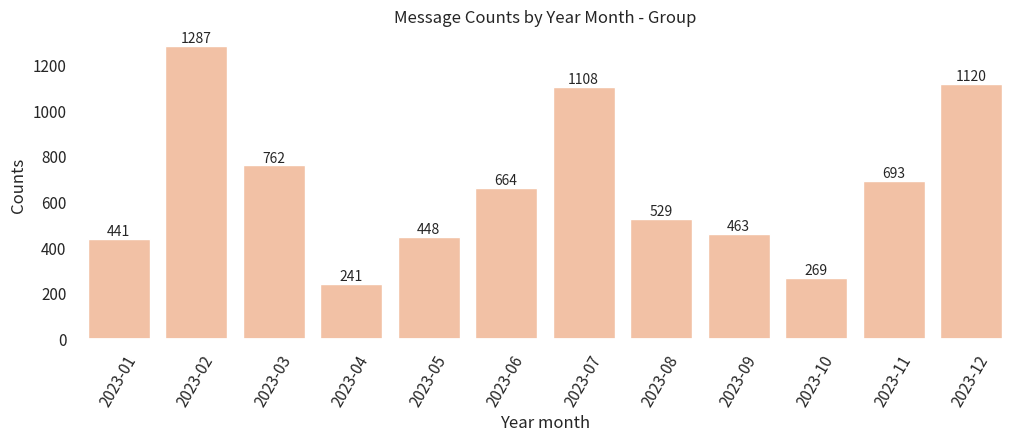

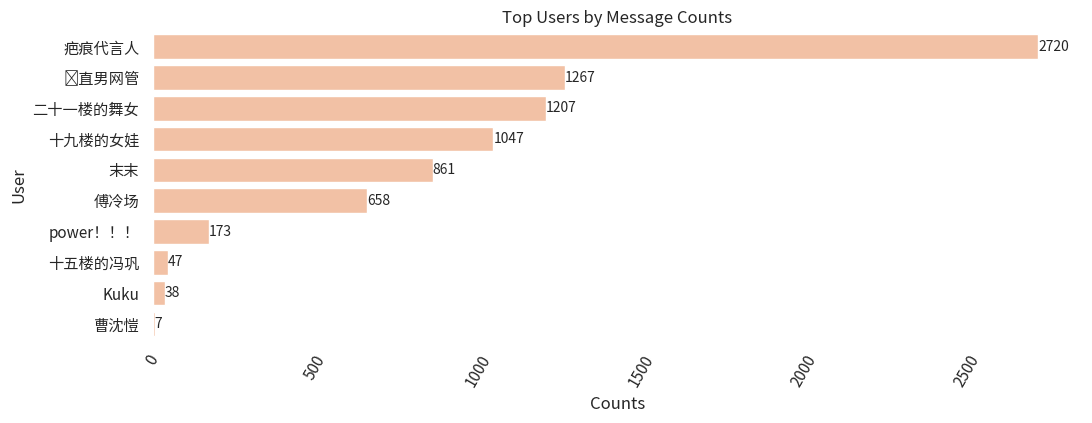

In [20]:
plot_bar_by_year_month(df, None)
plot_bar_by_user(df)

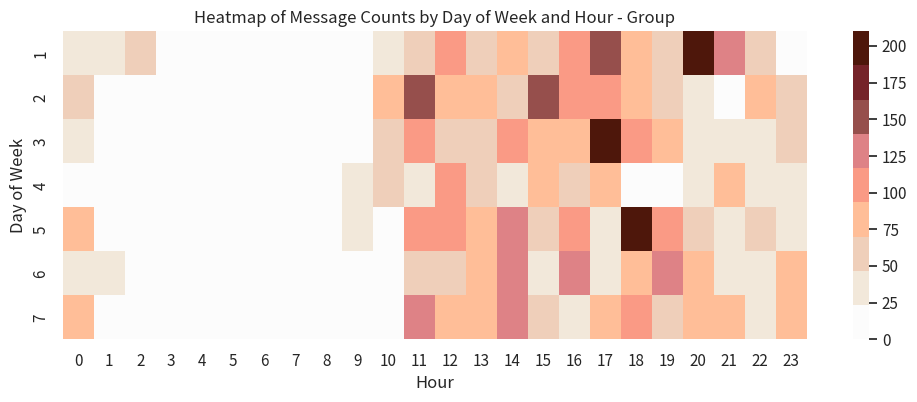

In [21]:
plot_heatmap_by_dow_hour(df, None)

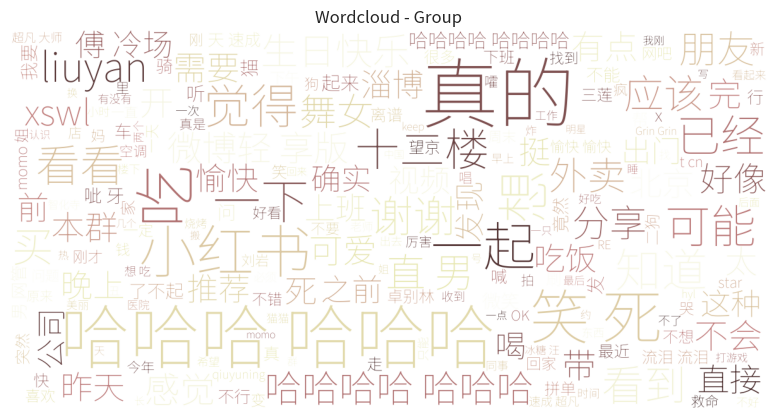

In [267]:
plot_wordcloud(df, None)

Overall Sentiment positive
Overall Sentiment Score 0.2962571687292484


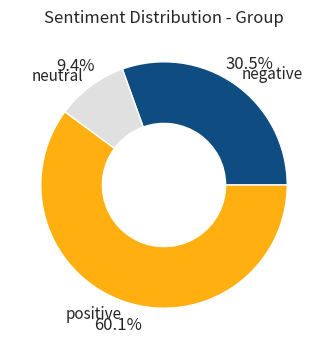

In [270]:
# Apply sentiment function to dataframe
# This may take 2-5 mins depends on your message count
df[['mood', 'mood_score']] = df['msg'].apply(classify_sentiment) # you only need to run this line once

overall_sentiment, overall_sentiment_score = calculate_sentiment_score(df[df['year']==2023], None)
print("Overall Sentiment", overall_sentiment)
print("Overall Sentiment Score", overall_sentiment_score)

plot_sentiment_contribution(df[df['year']==2023], None)

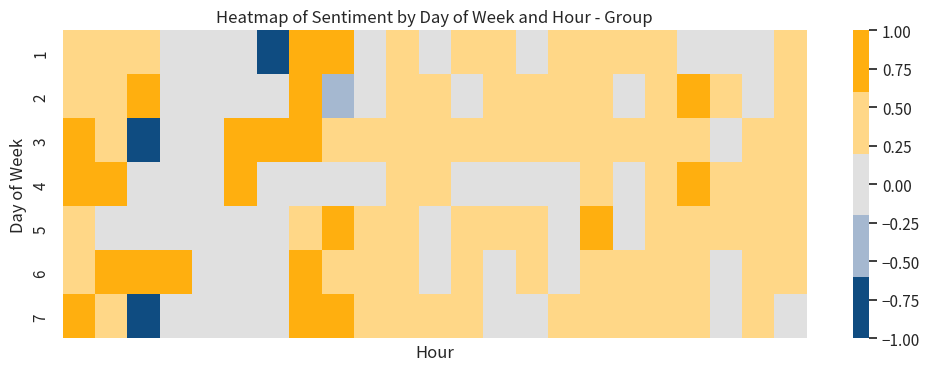

In [271]:
plot_sentiment_heatmap_by_dow_hour(df, None)

Correlation between sentimen score and message count:  -0.1684295028630222


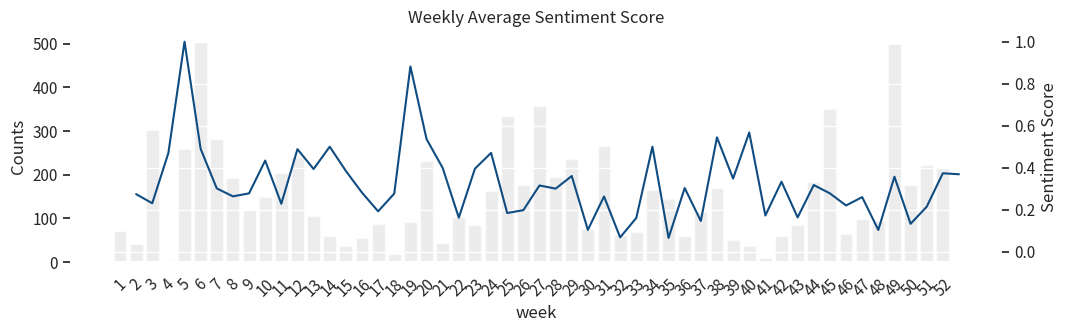

In [272]:
plot_timeseries_sentiment(df, None)

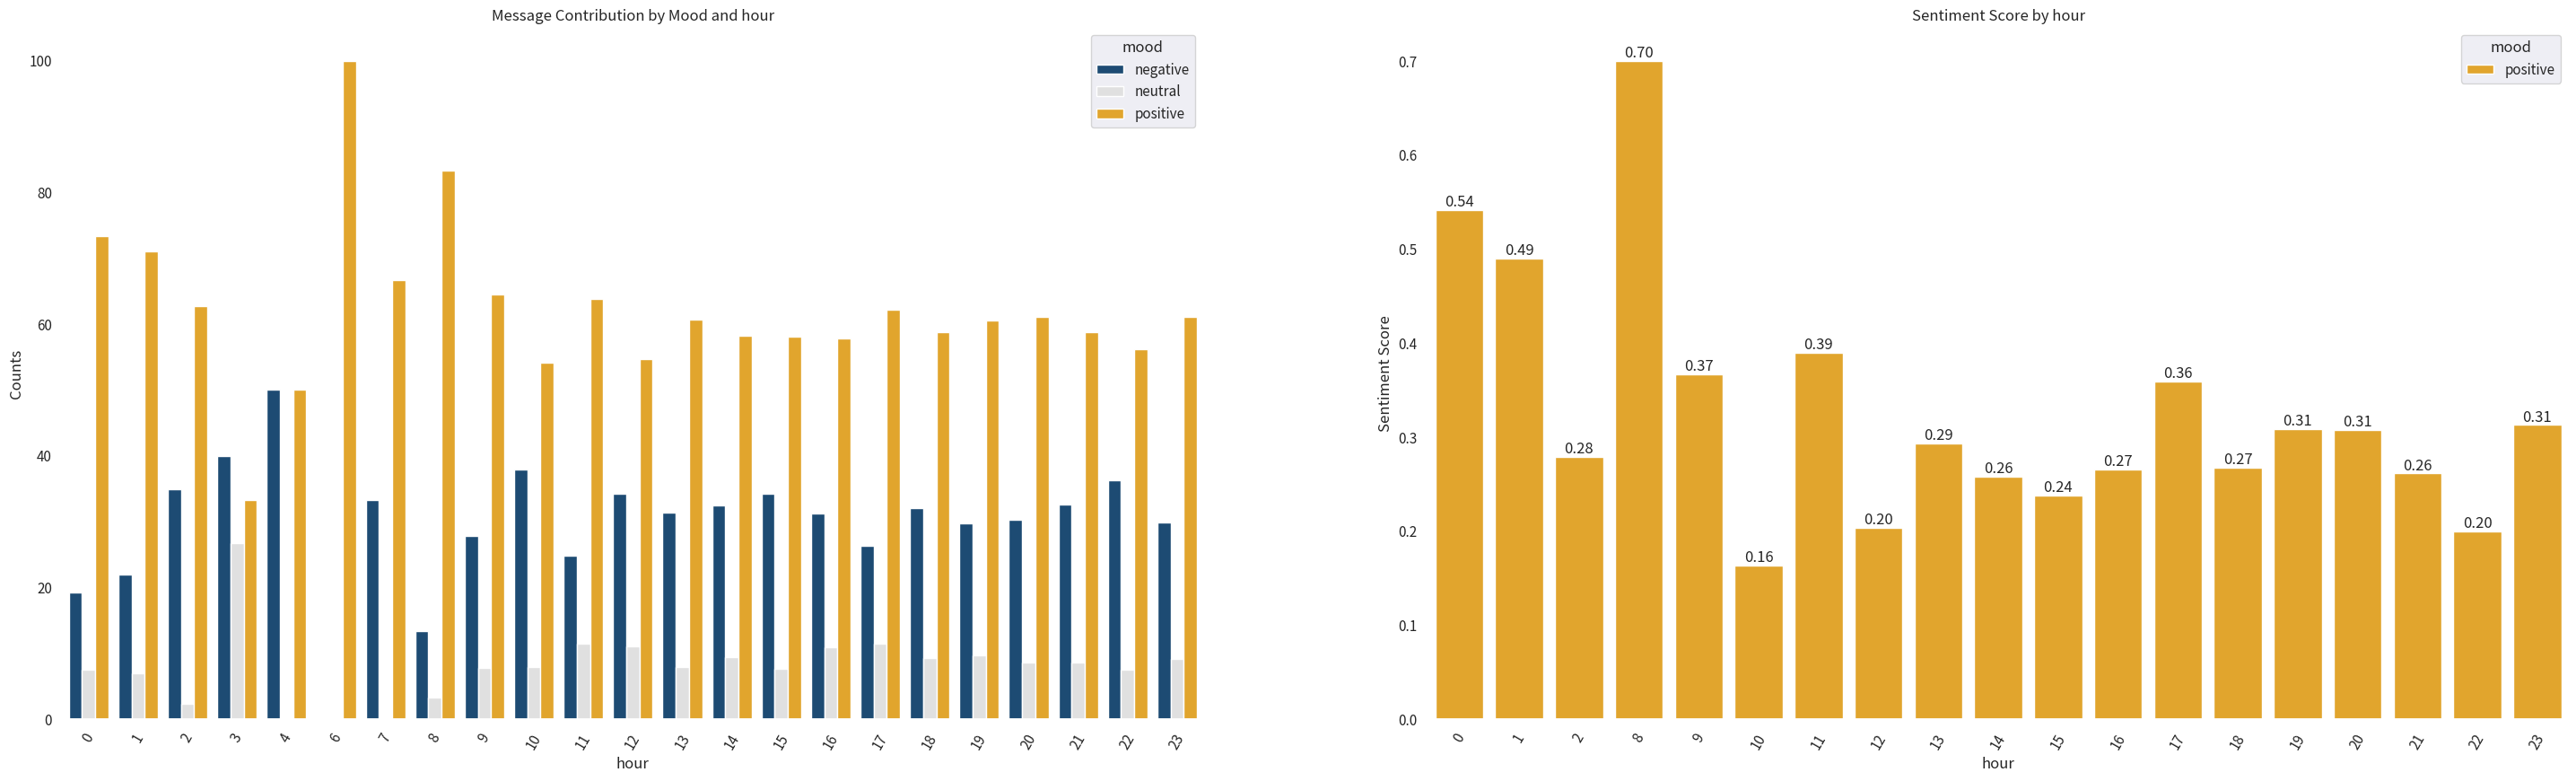

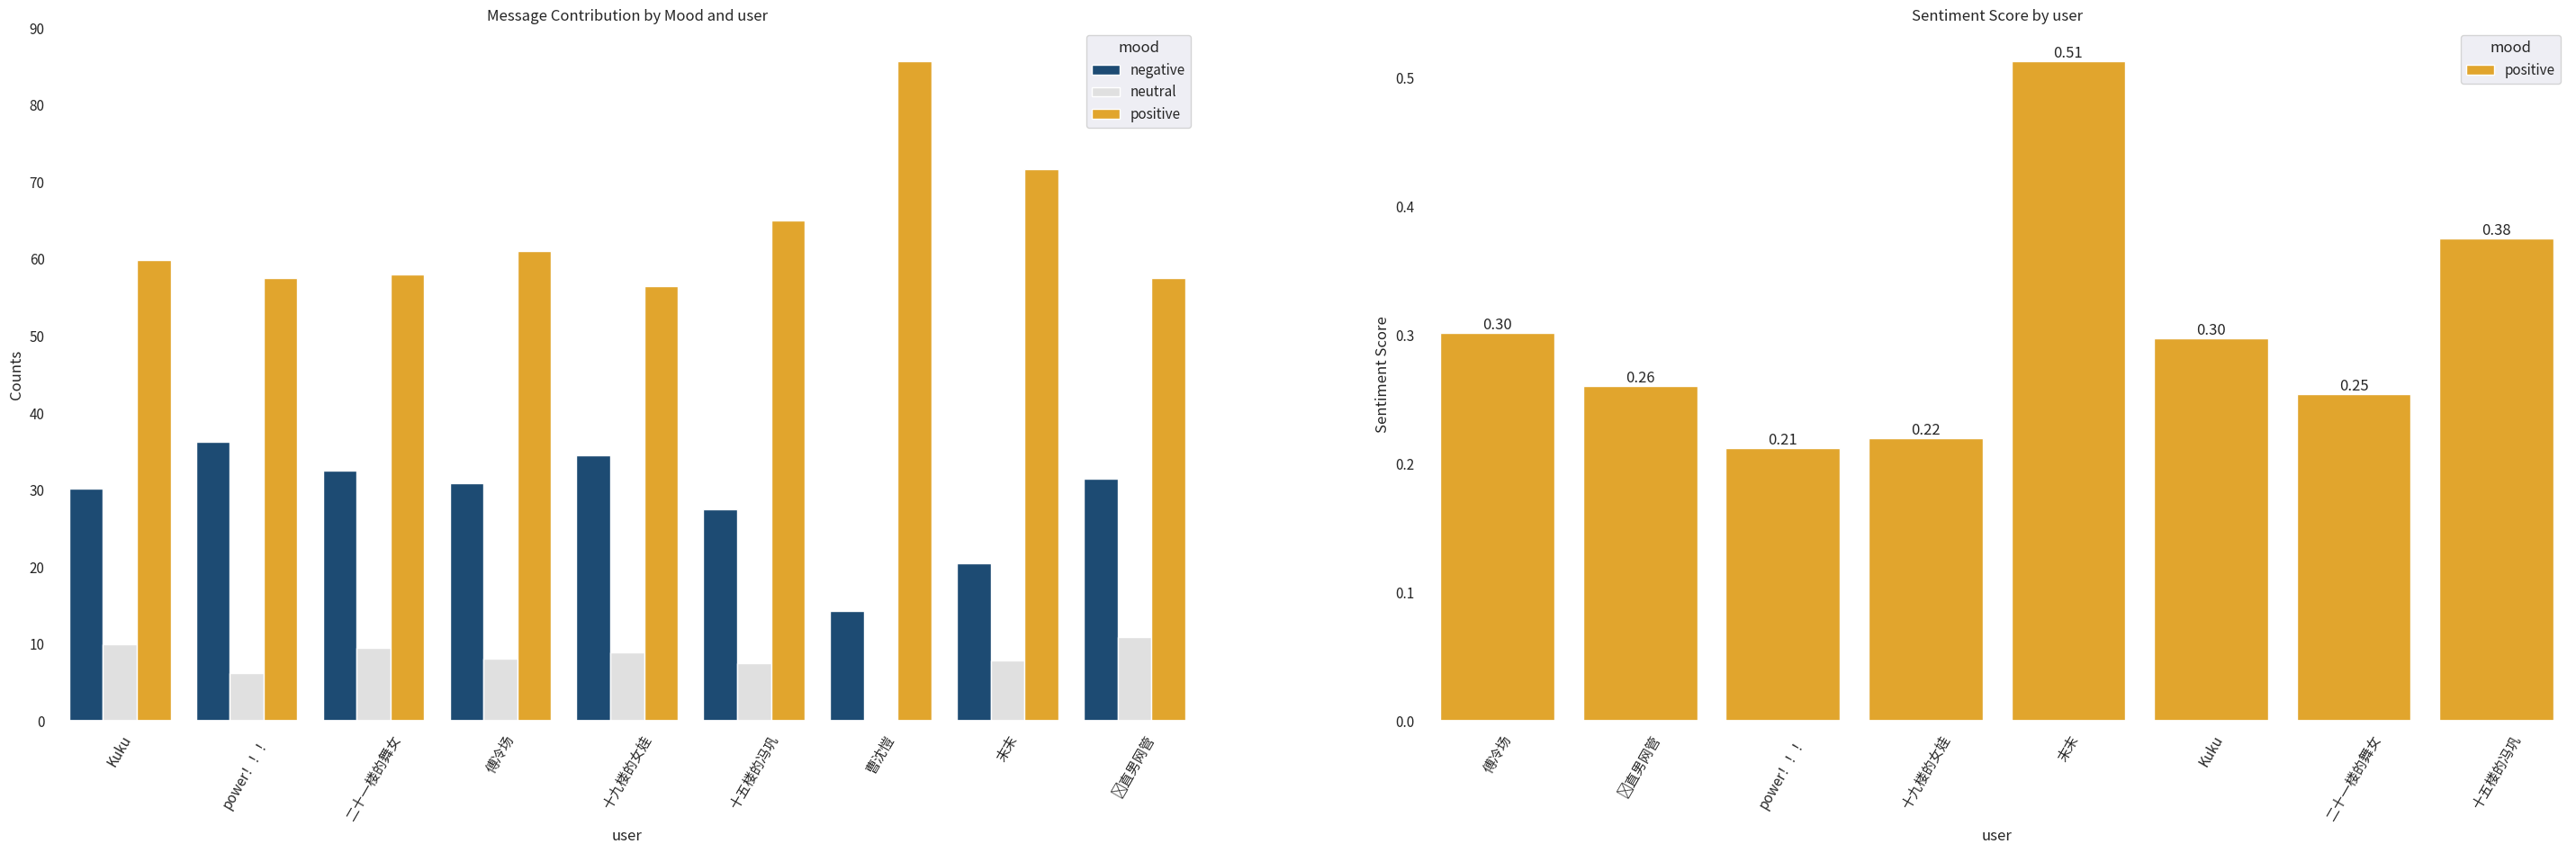

In [278]:
plot_sentiment_by_dimension(df, 'hour')
plot_sentiment_by_dimension(df, 'user')

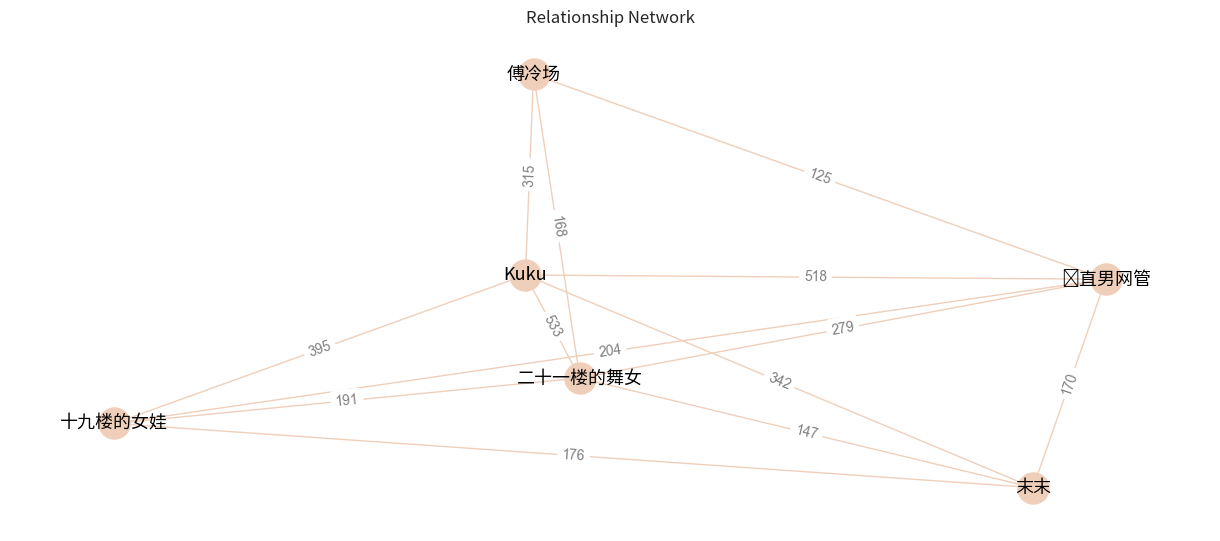

In [274]:
G = create_relationship_network(df)
plot_relationship_network(G, 100)

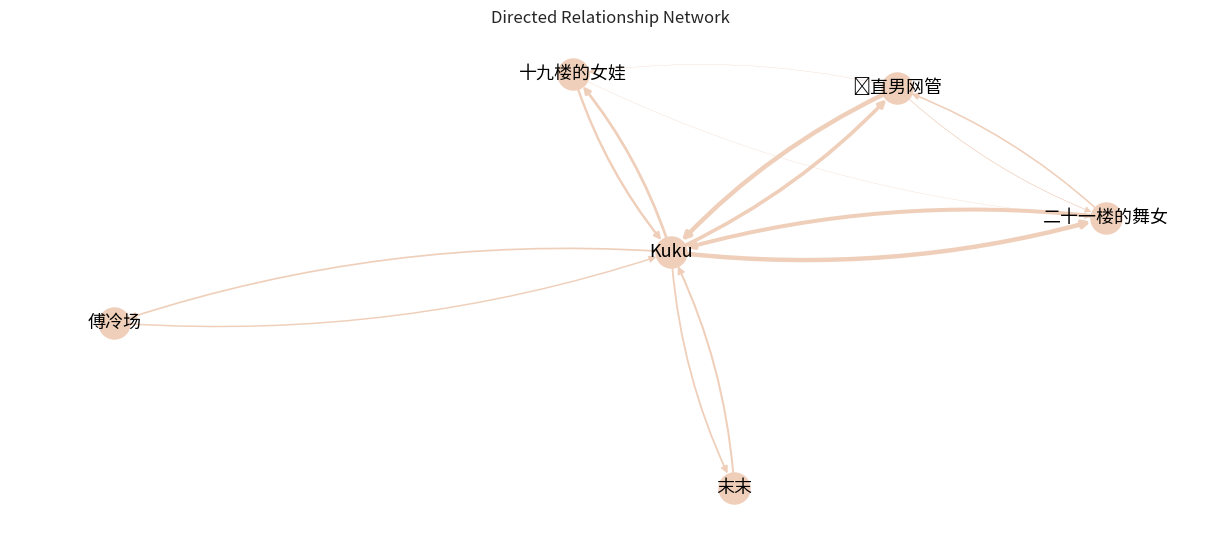

In [275]:
G = create_directed_relationship_network(df)
plot_relationship_network(G, 100)

In [ ]:
user_summary_df = user_summary(df)
user_summary_df.to_csv('user_summary_df.txt', sep='\t', index=False)

In [ ]:
monthly_summary_df = monthly_summarization(df)
monthly_summary_df.to_csv('monthly_summary_df.txt', sep='\t', index=False)

In [52]:
def understand_this_user(df, username):
    plot_bar_by_year_month(df, username)
    plot_heatmap_by_dow_hour(df, username)
    plot_wordcloud(df, username)
    
    mood, score = calculate_sentiment_score(df, username)
    print('Overall Sentiment:', mood)
    print('Overall Sentiment Score:', score)
    plot_sentiment_contribution(df, username)
    plot_timeseries_sentiment(df, username)
    plot_sentiment_heatmap_by_dow_hour(df, username)

#username = '末末'
#understand_this_user(df, username)